#HW6 Control with Approximation


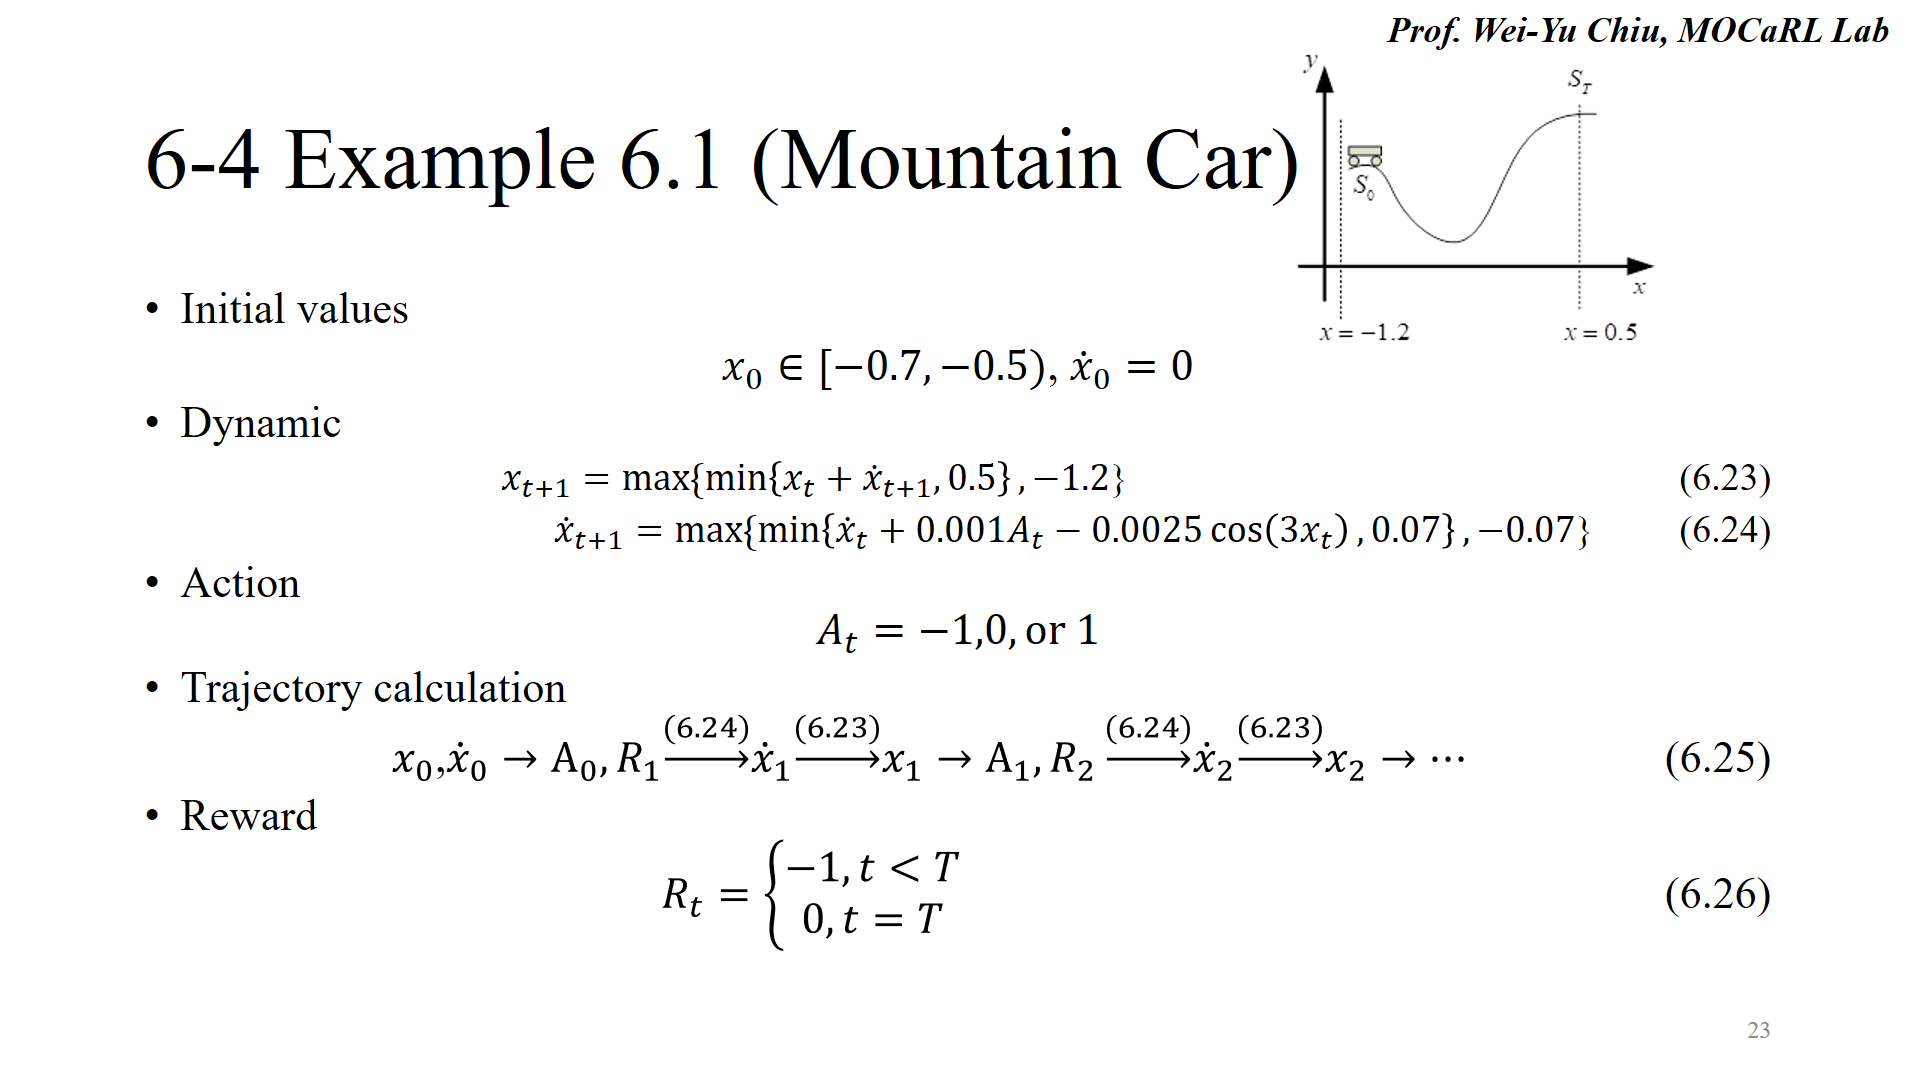

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rd

In [ ]:
# Environment
def step(state, action):
    position = state[0]
    velocity = state[1]
    acc = action -1
    new_velocity = velocity + 0.001 * acc - 0.0025 * np.cos(3 * position)
    new_velocity = min(max(-0.07, new_velocity), 0.07)
    new_position = position + new_velocity
    new_position = min(max(-1.2, new_position), 0.5)
    reward = -1.0
    if new_position == -1.2:
        new_velocity = 0.0
    return [new_position, new_velocity], reward

In [ ]:
# Tile coding
class Approximate_Q_learning():
    def __init__(self):

        self.alpha = 0.05
        self.gamma = 0.99
        self.epsilon = 0.005

        # set up position tile
        pos_range = [-1.2, 0.5]
        pos_side_num = 15
        l_pos = pos_side_num / (pos_side_num - 1 + 1 / 3) #6.13
        p_pos = l_pos / (3 * pos_side_num) #6.14

        # set up velocity tile
        vel_range = [-0.07, 0.07]
        vel_side_num = 5
        l_vel = vel_side_num/(vel_side_num-1+1/3) #6.13
        p_vel = l_vel/(3*vel_side_num) #6.14

        # set up tiling 1
        pos_range1 = [pos_range[0], pos_range[1] + 2*p_pos]
        vel_range1 = [vel_range[0], vel_range[1] + 2*p_vel]

        # set up tiling 2
        pos_range2 = [pos_range[0] - p_pos, pos_range[1] + p_pos]
        vel_range2 = [vel_range[0] - p_vel, vel_range[1] + p_vel]

        # set up tiling 3
        pos_range3 = [pos_range[0] - 2*p_pos, pos_range[1]]
        vel_range3 = [vel_range[0] - 2*p_vel, vel_range[1]]

        # make grid in tiling 1
        self.pos_bin1 = np.linspace(pos_range1[0], pos_range1[1], num=pos_side_num)
        self.vel_bin1 = np.linspace(vel_range1[0], vel_range1[1], num=vel_side_num)

        # make grid in tiling 2
        self.pos_bin2 = np.linspace(pos_range2[0], pos_range2[1], num=pos_side_num)
        self.vel_bin2 = np.linspace(vel_range2[0], vel_range2[1], num=vel_side_num)

        # make grid in tiling 3
        self.pos_bin3 = np.linspace(pos_range3[0], pos_range3[1], num=pos_side_num)
        self.vel_bin3 = np.linspace(vel_range3[0], vel_range3[1], num=vel_side_num)

        # make storage space to weight of tiling1 and tiling2
        self.tiling1 = np.zeros([pos_side_num, vel_side_num, 3])
        self.tiling2 = np.zeros([pos_side_num, vel_side_num, 3])
        self.tiling3 = np.zeros([pos_side_num, vel_side_num, 3])

    # check which tile would be activated
    def state_coding(self, state):
        i_pos1 = np.digitize([state[0]], self.pos_bin1, right=True)[0]
        i_vel1 = np.digitize([state[1]], self.vel_bin1, right=True)[0]

        i_pos2 = np.digitize([state[0]], self.pos_bin2, right=True)[0]
        i_vel2 = np.digitize([state[1]], self.vel_bin2, right=True)[0]

        i_pos3 = np.digitize([state[0]], self.pos_bin3, right=True)[0]
        i_vel3 = np.digitize([state[1]], self.vel_bin3, right=True)[0]

        return (i_pos1, i_vel1, i_pos2, i_vel2, i_pos3, i_vel3)

    # evaluate q-value
    def evaluate_Q(self, coded_state, action):
        Q = self.tiling1[coded_state[0], coded_state[1], action] + self.tiling2[coded_state[2], coded_state[3], action] + self.tiling3[coded_state[4], coded_state[5], action]
        return Q 
    # update weight of tile
    def update_Q(self, state, action, reward, next_state, S_t):

        coded_state = self.state_coding(state)
        coded_next_state = self.state_coding(next_state)
        Q = self.evaluate_Q(coded_state, action)

        if next_state[0] >= S_t:
            self.tiling1[coded_state[0], coded_state[1], action] += self.alpha * (reward - Q)
            self.tiling2[coded_state[2], coded_state[3], action] += self.alpha * (reward - Q)
            self.tiling3[coded_state[4], coded_state[5], action] += self.alpha * (reward - Q)
        else:
            Q_ = np.max([self.evaluate_Q(coded_next_state, i) for i in range(3)])
            self.tiling1[coded_state[0], coded_state[1], action] += self.alpha * (reward + self.gamma * Q_ - Q)
            self.tiling2[coded_state[2], coded_state[3], action] += self.alpha * (reward + self.gamma * Q_ - Q)
            self.tiling3[coded_state[4], coded_state[5], action] += self.alpha * (reward + self.gamma * Q_ - Q)

    # epsilon greedy action
    def act(self, state):
        coded_state = self.state_coding(state)

        if np.random.rand() < self.epsilon:
            action = np.random.randint(3)
        else:
            action = np.argmax([self.evaluate_Q(coded_state, i) for i in range(3)])
        return action

In [ ]:
# Simulation
def agent_Q():
    episodes = 500
    returns = np.zeros((episodes))
    agent = Approximate_Q_learning()

    for episode in range(episodes):

        state = [np.random.uniform(-0.7, -0.5), 0]

        G = 0
        while state[0] < 0.5:
            action = agent.act(state)
            state_next, reward = step(state, action)
            agent.update_Q(state, action, reward, state_next, S_t=0.5)
            state = state_next
            G += reward

        print(episode, ' episode returns: ', G)

        returns[episode] = G

    return returns


#Example function

0  episode returns:  -2836.0
1  episode returns:  -2019.0
2  episode returns:  -648.0
3  episode returns:  -618.0
4  episode returns:  -705.0
5  episode returns:  -4653.0
6  episode returns:  -9787.0
7  episode returns:  -16664.0
8  episode returns:  -1692.0
9  episode returns:  -4403.0
10  episode returns:  -472.0
11  episode returns:  -8033.0
12  episode returns:  -3353.0
13  episode returns:  -613.0
14  episode returns:  -468.0
15  episode returns:  -1412.0
16  episode returns:  -462.0
17  episode returns:  -699.0
18  episode returns:  -806.0
19  episode returns:  -391.0
20  episode returns:  -344.0
21  episode returns:  -728.0
22  episode returns:  -2431.0
23  episode returns:  -292.0
24  episode returns:  -295.0
25  episode returns:  -431.0
26  episode returns:  -337.0
27  episode returns:  -223.0
28  episode returns:  -235.0
29  episode returns:  -224.0
30  episode returns:  -227.0
31  episode returns:  -144.0
32  episode returns:  -297.0
33  episode returns:  -218.0
34  episode 

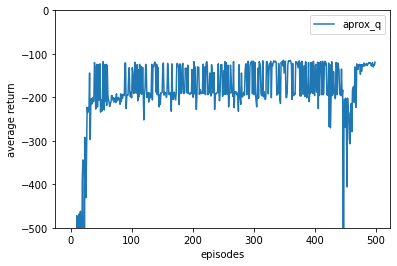

In [ ]:
returns = agent_Q()
plt.plot(returns,label='aprox_q')
plt.xlabel("episodes")
plt.ylabel('average return')
plt.ylim(-500, 0)
plt.legend()
plt.show()

#Question 1(20%)
Please see the 11 line in the following algorithm, what is the corresponding concept to the  Q-table method?
Why  it can't be coded like Q-table method?

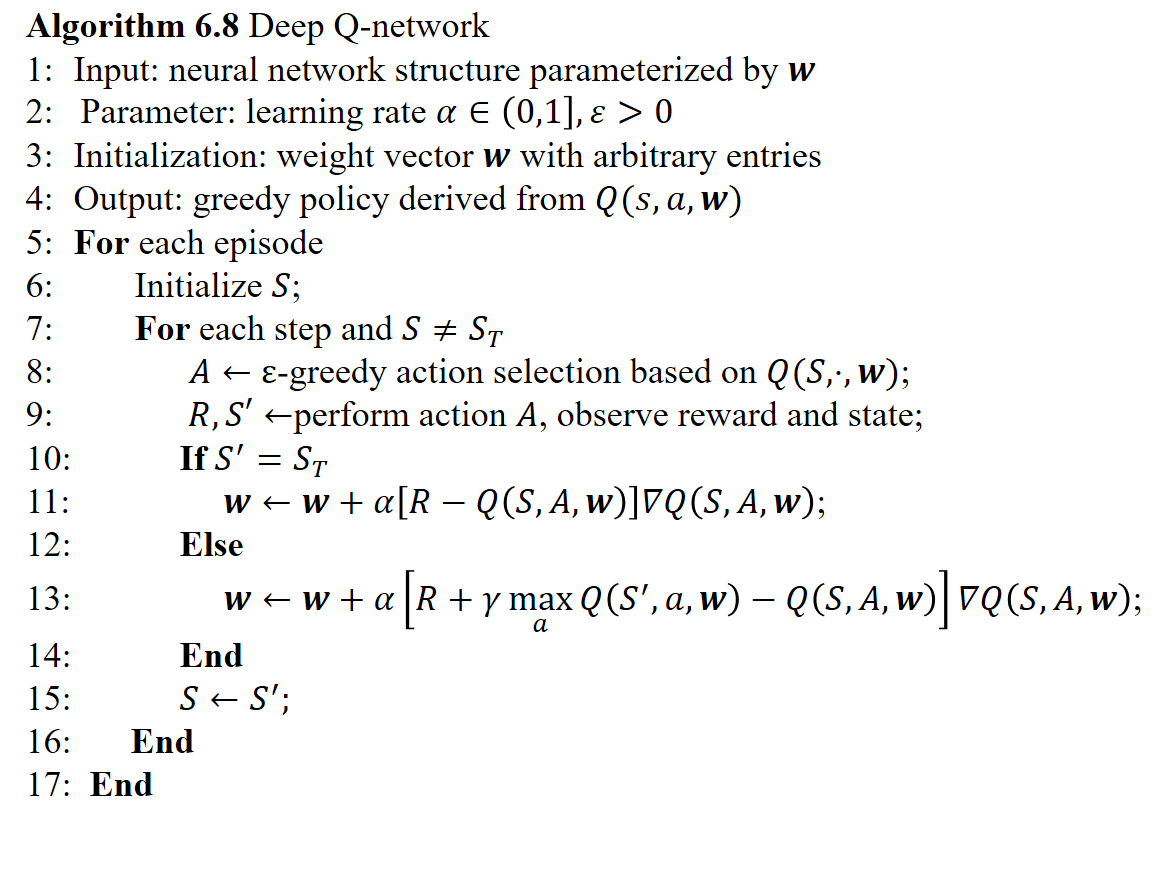

Ans 1.



$In\;Deep\;Q-netwok:\textbf{w}\,\leftarrow\,\textbf{w}+\alpha[R-Q(S,A,\textbf{w})]\nabla Q(S,A,\textbf{w})\\Similar\;to\;Q-table\;method:Q(S^\prime,A^\prime,\textbf{w})=0$

在Approximate Solution Method中，通常使用w去update value，然而某一點的w代表的不是僅為Q-table中的一點，還包含鄰近區域。

因此在Approximate Solution Method中，無法透過設定終點一處的value = 0去表示terminal state。

# Experiment 1 (20%)
In Sarsa or Q-learning set learning rate to 0.9~0.1 usually work well, but in approximation method set learning rate to 0.1 is too big, please test the  learning rate(self.alpha) in these numbers [0.5 0.1 0.05 0.01 0.005 0.001], and make a graph, x-axis is learning rate y-axis is average of last 100 episode returns, you can break your simulation and set average return to -500,000,when an episode have return lower than -500,000.

Ans E1.

由下圖可看出不同 learning rate 之下，average of last 100 episode returns 的變化。

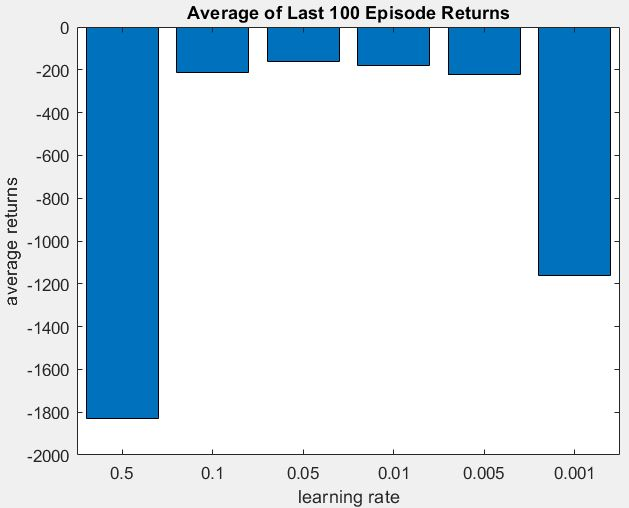

$\bullet\,Learning\;Rate=0.5\;(Last\,100\,Average\,Return:-1829.75)$

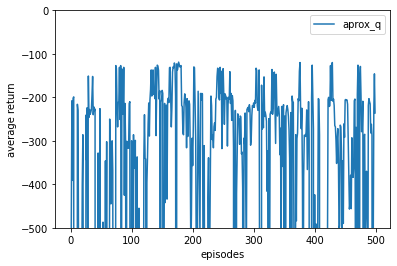

$\bullet\,Learning\;Rate=0.1\;(Last\,100\,Average\,Return:-213.18)$

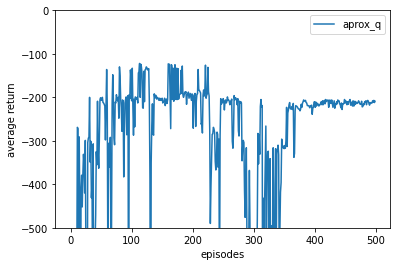

$\bullet\,Learning\;Rate=0.05\;(Last\,100\,Average\,Return:-160.12)$

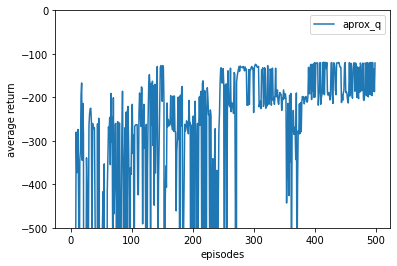

$\bullet\,Learning\;Rate=0.01\;(Last\,100\,Average\,Return:-178.24)$

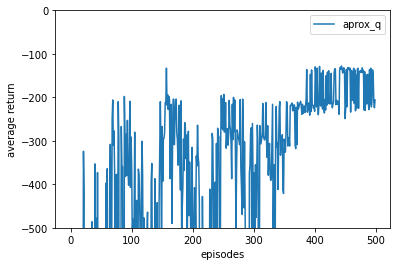

$\bullet\,Learning\;Rate=0.005\;(Last\,100\,Average\,Return:-223.74)$


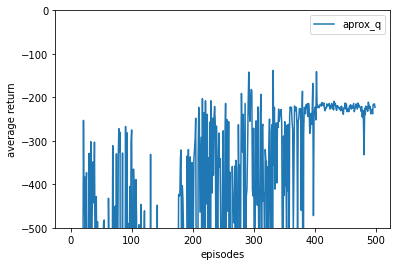

$\bullet\,Learning\;Rate=0.001\;(Last\,100\,Average\,Return:-1160.62)$

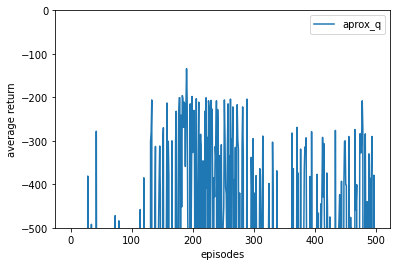

# Experiment 2 (60%)
Example code have 2 tilings, please make the 3 tilings version, the average of last 100 episode returns must higher than -300, plot your result like emaple.

Ans E2.

Average of last 100 episode returns:  -178.21

(已修改完成前面程式碼為 3 tilings version)

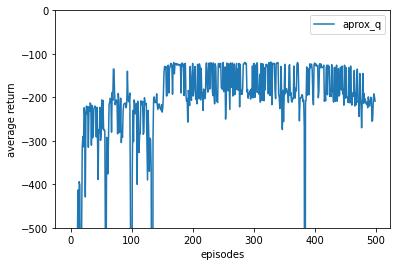